In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.models import Model

import os, shutil, random, cv2

## Unzipping the data

In [0]:
!unzip 'chest_xray.zip'

In [0]:
test_data = 'chest_xray/test'
train_data = 'chest_xray/train'
val_data = 'chest_xray/val'

In [0]:
# Function to create dir
def create(dirname, destpath):
    full_path = os.path.join(destpath, dirname)
    if os.path.isdir(full_path):
      print(dirname + ' dir already exist')
      return full_path
    else:
      os.mkdir(full_path)
      print(dirname + ' dir created')
      return full_path

def create_dir_mv_files(srcpath, destpath):
  if not os.path.isdir(srcpath):
    print(srcpath + ' does not exist')
    return 0
  try:
      os.remove(srcpath+'/.DS_Store')
      print('.DS_Store deleted')
  except OSError:
      print('.DS_Store already deleted')
  
  srcfiles = os.listdir(srcpath)
  destdirs = list(set([filename.split('_')[1] for filename in srcfiles]))
  destdirs = ['PNEUMONIA_'+x.upper() for x in destdirs]

  def move(filename, dirpath):
      shutil.move(os.path.join(srcpath, filename), dirpath)

  targets = [(folder, create(folder, destpath)) for folder in destdirs]
  for dirname, full_path in targets:
      for filename in srcfiles:
          if dirname.split('_')[1].lower() == filename.split('_')[1]:
              move(filename, full_path)
  
  os.rmdir(srcpath)
  print('Files moved with success from',srcpath,'to',destpath)

In [7]:
# Move the train set
srcpath_train = './chest_xray/train/PNEUMONIA'
destpath_train = './chest_xray/train/'
create_dir_mv_files(srcpath_train, destpath_train)

# Move the test set
srcpath_test = './chest_xray/test/PNEUMONIA'
destpath_test = './chest_xray/test/'
create_dir_mv_files(srcpath_test, destpath_test)

# Move the validation set
srcpath_val = './chest_xray/val/PNEUMONIA'
destpath_val = './chest_xray/val/'
create_dir_mv_files(srcpath_val, destpath_val)

# So that the Validation set has also 3 classes
create('PNEUMONIA_VIRUS', destpath_val)

.DS_Store deleted
PNEUMONIA_BACTERIA dir created
PNEUMONIA_VIRUS dir created
Files moved with success from ./chest_xray/train/PNEUMONIA to ./chest_xray/train/
.DS_Store already deleted
PNEUMONIA_BACTERIA dir created
PNEUMONIA_VIRUS dir created
Files moved with success from ./chest_xray/test/PNEUMONIA to ./chest_xray/test/
.DS_Store deleted
PNEUMONIA_BACTERIA dir created
Files moved with success from ./chest_xray/val/PNEUMONIA to ./chest_xray/val/
PNEUMONIA_VIRUS dir created


'./chest_xray/val/PNEUMONIA_VIRUS'

## Printing Images

In [0]:
# Function to print images
def print_imgs(path, img_to_print):
    fig = plt.figure(figsize=(12,7))
    img_printed = 0
    for file in os.listdir(path):
        if img_printed == img_to_print:
            break
        
        img = mpimg.imread(os.path.join(path, file))
        plt.title(file)
        plt.subplot(2, img_to_print/2, img_printed+1)
        img_plot = plt.imshow(img)
        img_printed += 1

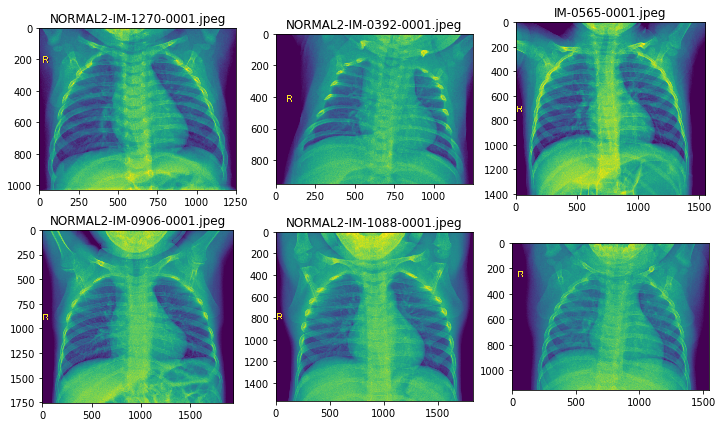

In [9]:
# Print train NORMAL images
print_imgs(train_data + '/NORMAL', 6)

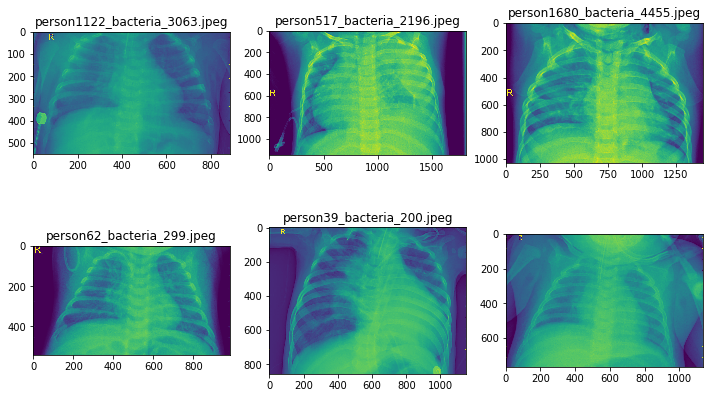

In [10]:
# Print train PNEUMONIA BACTERIA images
print_imgs(train_data + '/PNEUMONIA_BACTERIA', 6)

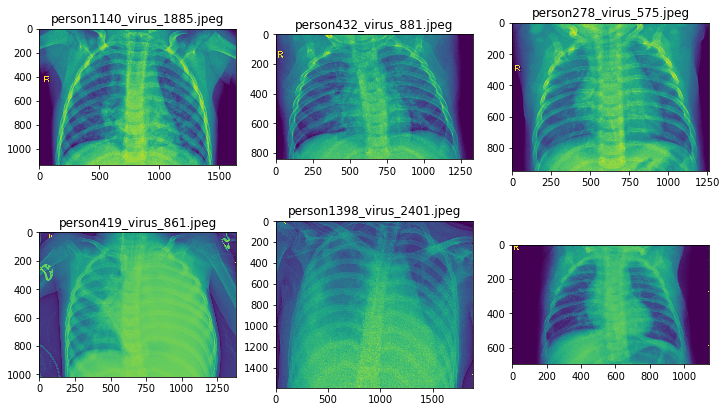

In [11]:
# Print train PNEUMONIA VIRUS images
print_imgs(train_data + '/PNEUMONIA_VIRUS', 6)

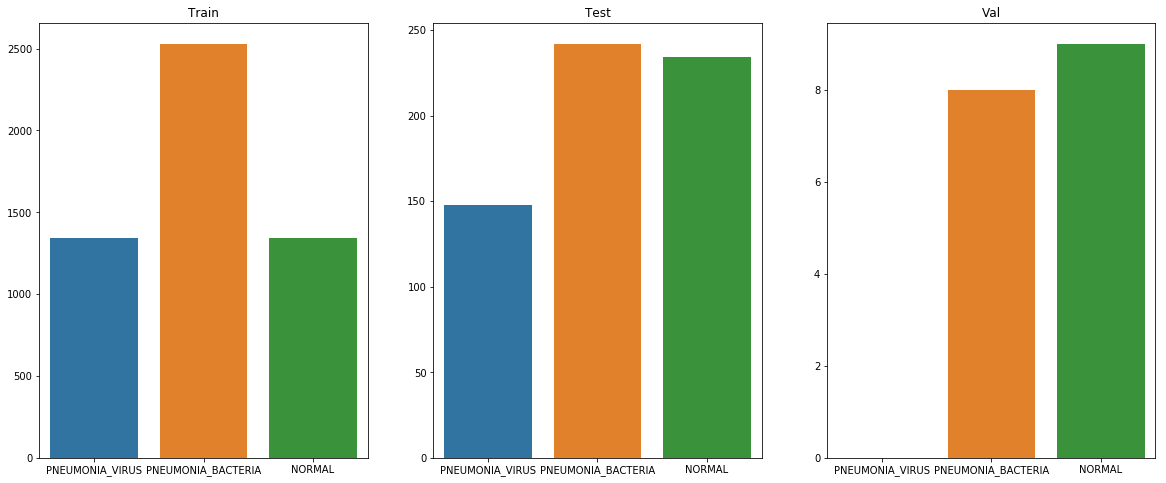

In [12]:
# Print the amount of data
def count_cases(data_dir):
    subdirs = os.listdir(data_dir)

    subdir_names = []
    subdir_file_count = []

    for subdir in subdirs:
        if (subdir == '.DS_Store'):
            continue
        current_dir = os.path.join(data_dir, subdir)
        file_count = len(os.listdir(current_dir))
        subdir_names.append(subdir)
        subdir_file_count.append(file_count)
    
    return subdir_names, subdir_file_count
    
def make_bar_plot(data_dir, title, subplot_num):
    x, y = count_cases(data_dir)
    plt.subplot(subplot_num)
    sns.barplot(x=x, y=y)
    plt.title(title)
    plt.xticks(range(len(x)), x)
 
def show_file_count(train_dir, test_dir, val_dir):
    plt.figure(figsize=(20,8))
    
    title = 'Train'
    subplot_num = 131
    make_bar_plot(train_dir, title, subplot_num)
    
    
    title = 'Test'
    subplot_num = 132
    make_bar_plot(test_dir, title, subplot_num)
    
    
    title = 'Val'
    subplot_num = 133
    make_bar_plot(val_dir, title, subplot_num)
    
    plt.show()

show_file_count(train_data, test_data, val_data)


## Train the Model

In [13]:
# Parameters of the model
rescale = 1./255.
target_size = (150,150)
batch_size = 64
class_mode = 'categorical'

# Train data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

# Test data
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

# Validation data
val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

Found 5216 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 16 images belonging to 3 classes.


In [0]:
# InceptionV3
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
  x = base_model.output
  # from Keras
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.4)(x)
  x = Dense(1024, activation='relu')(x)
  x = BatchNormalization()(x)
  
  predictions = Dense(3, activation='softmax')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [15]:
# Get the model
model = get_model()









87916544/87910968 [==============================] - 5s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
act

In [16]:
# Fit the model
optimizer = keras.optimizers.Adam(0.001)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
82/82 [==============================] - 99s 1s/step - loss: 1.0318 - acc: 0.6351 - val_loss: 3.4962 - val_acc: 0.3942
Epoch 2/20
82/82 [==============================] - 85s 1s/step - loss: 0.7571 - acc: 0.6677 - val_loss: 1.4201 - val_acc: 0.5865
Epoch 3/20
82/82 [==============================] - 87s 1s/step - loss: 0.6956 - acc: 0.6829 - val_loss: 2.7665 - val_acc: 0.4840
Epoch 4/20
82/82 [==============================] - 87s 1s/step - loss: 0.7015 - acc: 0.6890 - val_loss: 2.2829 - val_acc: 0.3942
Epoch 5/20
82/82 [==============================] - 87s 1s/step - loss: 0.6773 - acc: 0.6970 - val_loss: 3.8746 - val_acc: 0.2772
Epoch 6/20
82/82 [==============================] - 87s 1s/step - loss: 0.6848 - acc: 0.6896 - val_loss: 1.3353 - val_acc: 0.5561
Epoch 7/20
82/82 [==============================] - 88s 1s/step - loss: 0.6686 - acc: 0.7001 - val_loss: 1.3970 - val_acc: 0.

## Valuation

In [17]:
result  = model.evaluate_generator(val_generator, steps=len(val_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1] * 100)

1/1 [==============================] - 1s 754ms/step
Loss: 1.0405185222625732
Accuracy: 68.75


## Visualization

In [0]:

def show_predictions(y_real, y_pred, class_map, test_dir, sample=True):
    #fig, axs = get_fig_axs(subplot_params)
    #plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    #plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    plt.figure(figsize=(12,6))
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_real)
    cant_img = 8
    for i in range(0, cant_img): 
        num = i
        if (sample):
            num = random.randint(0, length-1)
            for num in m:
                num = int(random.randint(0, length-1))

            m[num]=1

        plt.subplot(2, cant_img/2, i+1)
        img = cv2.imread(test_dir+"/"+ file_names[num], 1)
        plt.imshow(img)
        
        original = class_map[y_real[num][0]]
        predicted = class_map[y_pred[num][0]]
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        
        if (original == predicted):
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')  
            
    plt.tight_layout()
    plt.show()

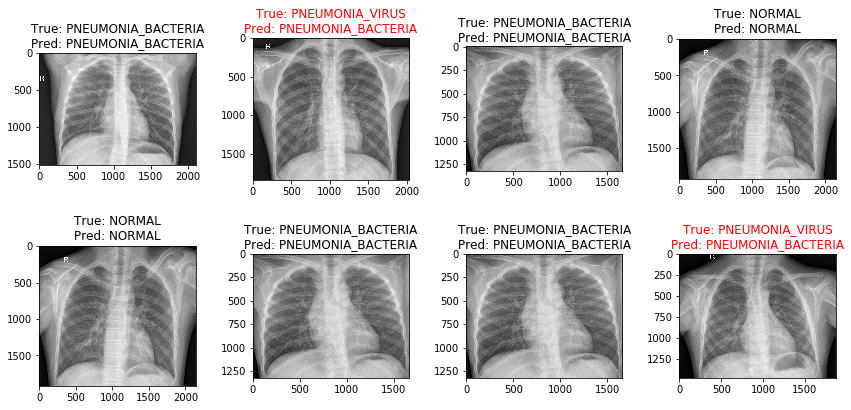

In [179]:
# Test the model
cant_img_pred = 8
y_img_list = []
y_pred_list = []
for i in range(cant_img_pred):
    rand_img_num = random.randint(0, len(test_generator) - 1)
    y_img_test, y_real_img = test_generator[rand_img_num]
    y_real_img = y_real_img.argmax(axis=-1)
    y_pred = model.predict(y_img_test)
    y_pred = y_pred.argmax(axis=-1)
    y_img_list.append(y_real_img)
    y_pred_list.append(y_pred)

class_map = {v: k for k, v in test_generator.class_indices.items()}

show_predictions(y_img_list, y_pred_list, class_map, test_data)
#print(num)